# Predicción del tipo de institución de egreso en titulados de educación superior en Chile mediante técnicas de Machine Learning

Integrantes: Raúl Urzúa, Adán Marchena

Institución: Universidad de Las Américas

Programa: Magíster en Data Science

## Introducción

## 1. Introducción

La educación superior cumple un rol fundamental en el desarrollo social y económico de un país, 
siendo la formación de capital humano uno de los principales mecanismos para mejorar la productividad 
y reducir brechas de desigualdad. En Chile, el sistema de educación superior se caracteriza por una 
estructura diversa, compuesta por universidades, institutos profesionales y centros de formación técnica, 
cada uno con enfoques formativos y perfiles de egreso diferenciados.

El análisis de los titulados de educación superior permite comprender patrones asociados a la duración 
de los estudios, características demográficas de los estudiantes y diferencias entre áreas del conocimiento 
y tipos de instituciones. En este contexto, el uso de técnicas de Machine Learning ofrece herramientas 
adecuadas para identificar relaciones complejas entre variables y realizar predicciones a partir de datos 
históricos.

El objetivo de este trabajo es evaluar la capacidad de distintos modelos de aprendizaje supervisado 
para predecir la probabilidad de sobre-duración en la titulación de los titulados de educación superior en Chile, utilizando 
información académica y demográfica proveniente de datos abiertos correspondientes a los años 2022, 2023 y 2024. 
Adicionalmente, se comparará el desempeño de modelos lineales, basados en árboles y métodos de ensamble, 
empleando métricas estándar de evaluación y validación cruzada.

Este estudio busca aportar evidencia empírica sobre la utilidad de los enfoques de Machine Learning en el 
análisis de datos educacionales, así como entregar una comparación metodológica que permita evaluar 
las fortalezas y limitaciones de distintos algoritmos aplicados a un problema de clasificación multiclase.


## 2. Descripción de los datos

In [65]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay

from utils import load_dataset, basic_overview

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.2f}".format)

### 2.1 Fuente de datos

Los datos utilizados en este estudio provienen de registros oficiales de titulados de educación superior 
en Chile, correspondientes a los años 2022, 2023 y 2024. Estos conjuntos de datos incluyen información 
demográfica de los estudiantes, características académicas de las carreras cursadas y antecedentes de las 
instituciones de egreso. Los datos fueron integrados en una única base, permitiendo un análisis conjunto 
y comparativo a lo largo del período estudiado.


In [2]:
# Carga de datos
df_2022 = pd.read_csv("20250718_Titulados_Ed_Superior_2022_WEB.csv", sep=";", encoding="utf-8")
df_2023 = pd.read_csv("20250718_Titulados_Ed_Superior_2023_WEB.csv", sep=";", encoding="utf-8")
df_2024 = pd.read_csv("20250718_Titulados_Ed_Superior_2024_WEB.csv", sep=";", encoding="utf-8")

In [3]:
# Inspección básica
for year, df in zip([2022, 2023, 2024], [df_2022, df_2023, df_2024]):
    print(f"\nAño {year}")
    print(df.shape)


Año 2022
(291453, 41)

Año 2023
(299796, 41)

Año 2024
(302730, 41)


In [4]:
df_2022.head()

,cat_periodo,codigo_unico,mrun,gen_alu,fec_nac_alu,rango_edad,anio_ing_carr_ori,sem_ing_carr_ori,anio_ing_carr_act,sem_ing_carr_act,nombre_titulo_obtenido,nombre_grado_obtenido,fecha_obtencion_titulo,tipo_inst_1,tipo_inst_2,tipo_inst_3,cod_inst,nomb_inst,cod_sede,nomb_sede,cod_carrera,nomb_carrera,nivel_global,nivel_carrera_1,nivel_carrera_2,dur_estudio_carr,dur_proceso_tit,dur_total_carr,region_sede,provincia_sede,comuna_sede,jornada,modalidad,version,tipo_plan_carr,area_conocimiento,cine_f_97_area,cine_f_97_subarea,area_generica,cine_f_13_area,cine_f_13_subarea
0,2022,I70S1C574J2V1,43.00,2,199007,30 a 34 Años,2017,1,2017,1,NaN,MAGISTER EN ANALISIS SISTEMICO APLICADO A LA S...,20220506,Universidades,Universidades CRUCH,Universidades Estatales CRUCH,70,UNIVERSIDAD DE CHILE,1,SANTIAGO,574.00,MAGISTER EN ANALISIS SISTEMICO APLICADO A LA S...,Posgrado,Magister,Magister,4,0,4,Metropolitana,SANTIAGO,SANTIAGO,Vespertina,Presencial,1.00,Plan Regular,Ciencias Sociales,"Ciencias Sociales, Enseñanza Comercial y Derecho",Ciencias Sociales y del Comportamiento,Magister en Ciencias Sociales,"Ciencias Sociales, Periodismo e Información",Ciencias Sociales y del Comportamiento
1,2022,I69S1C5J1V1,150.00,2,199606,25 a 29 Años,2016,1,2016,1,PERIODISTA,LICENCIADO EN COMUNICACION SOCIAL,20220602,Universidades,Universidades CRUCH,Universidades Privadas CRUCH,69,UNIVERSIDAD ALBERTO HURTADO,1,CASA CENTRAL (SANTIAGO),5.00,PERIODISMO,Pregrado,Profesional Con Licenciatura,Carreras Profesionales,10,1,10,Metropolitana,SANTIAGO,SANTIAGO,Diurna,Presencial,1.00,Plan Regular,Ciencias Sociales,"Ciencias Sociales, Enseñanza Comercial y Derecho",Periodismo e Información,Periodismo,"Ciencias Sociales, Periodismo e Información",Periodismo e Información
2,2022,I13S6C160J1V1,151.00,2,199608,25 a 29 Años,2016,1,2016,1,FONOAUDIOLOGO,LICENCIADO EN FONOAUDIOLOGIA,20230213,Universidades,Universidades Privadas,Universidades Privadas,13,UNIVERSIDAD SANTO TOMAS,6,SEDE VIÑA DEL MAR,160.00,FONOAUDIOLOGIA,Pregrado,Profesional Con Licenciatura,Carreras Profesionales,10,0,10,Valparaíso,VALPARAISO,VIÑA DEL MAR,Diurna,Presencial,1.00,Plan Regular,Salud,Salud y Servicios Sociales,Medicina,Fonoaudiología,Salud y Bienestar,Salud
3,2022,I34S1C483J3V1,189.00,2,199605,25 a 29 Años,2021,1,2021,1,NO OTORGA TITULO,NO OTORGA GRADO,20220627,Universidades,Universidades CRUCH,Universidades Privadas CRUCH,34,UNIVERSIDAD DE LOS ANDES,1,CASA CENTRAL (SANTIAGO),483.00,DIPLOMADO EN DERECHO DE LA INFANCIA,Postítulo,Diplomado (desde un semestre),Postítulo,1,0,1,Metropolitana,SANTIAGO,LAS CONDES,Semipresencial,Semipresencial,1.00,Plan Regular,Derecho,"Ciencias Sociales, Enseñanza Comercial y Derecho",Derecho,Postítulo en Derecho,Administración de Empresas y Derecho,Derecho
4,2022,I3S1C46J1V1,239.00,2,199710,20 a 24 Años,1900,0,2017,1,ENFERMERA,LICENCIADA EN ENFERMERIA,20230123,Universidades,Universidades CRUCH,Universidades Privadas CRUCH,3,UNIVERSIDAD DIEGO PORTALES,1,CASA CENTRAL (SANTIAGO),46.00,ENFERMERIA,Pregrado,Profesional Con Licenciatura,Carreras Profesionales,10,0,10,Metropolitana,SANTIAGO,SANTIAGO,Diurna,Presencial,1.00,Plan Regular,Salud,Salud y Servicios Sociales,Medicina,Enfermería,Salud y Bienestar,Salud


In [5]:
df_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291453 entries, 0 to 291452
Data columns (total 41 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   cat_periodo             291453 non-null  int64  
 1   codigo_unico            291453 non-null  object 
 2   mrun                    290943 non-null  float64
 3   gen_alu                 291453 non-null  int64  
 4   fec_nac_alu             291453 non-null  int64  
 5   rango_edad              291453 non-null  object 
 6   anio_ing_carr_ori       291453 non-null  int64  
 7   sem_ing_carr_ori        291453 non-null  int64  
 8   anio_ing_carr_act       291453 non-null  int64  
 9   sem_ing_carr_act        291453 non-null  int64  
 10  nombre_titulo_obtenido  265146 non-null  object 
 11  nombre_grado_obtenido   129926 non-null  object 
 12  fecha_obtencion_titulo  291453 non-null  int64  
 13  tipo_inst_1             291453 non-null  object 
 14  tipo_inst_2         

Los datasets presentan una estructura homogénea entre años, lo que permite su integración directa.

In [6]:
df_2022 = load_dataset("20250718_Titulados_Ed_Superior_2022_WEB.csv", 2022)
df_2023 = load_dataset("20250718_Titulados_Ed_Superior_2023_WEB.csv", 2023)
df_2024 = load_dataset("20250718_Titulados_Ed_Superior_2024_WEB.csv", 2024)

basic_overview(df_2022)

{'filas': 291453, 'columnas': 42, 'nulos_totales': np.int64(196445)}

In [7]:
# Unificación de datasets
df = pd.concat([df_2022, df_2023, df_2024], ignore_index=True)
df.shape

(893979, 42)

In [8]:
df["nivel_global"].value_counts()

nivel_global
Pregrado     681919
Postítulo    149525
Posgrado      62535
Name: count, dtype: int64

In [9]:
df["Año"].value_counts()

Año
2024    302730
2023    299796
2022    291453
Name: count, dtype: int64

### 2.2 Selección de variables

A partir del conjunto total de variables disponibles, se realizó una selección inicial considerando su 
relevancia para el problema de clasificación planteado. Se priorizaron variables demográficas, académicas 
y de duración del proceso formativo, excluyendo identificadores directos de instituciones con el fin de 
evitar filtración de información (data leakage) y favorecer la capacidad de generalización de los modelos.

La variable objetivo corresponde al tipo de institución de egreso, mientras que las variables predictoras 
incluyen atributos asociados al estudiante, la carrera y el contexto institucional.



In [10]:
# Selección incicial de variables
selected_columns = [
    "Año",
    "gen_alu",
    "rango_edad",
    "tipo_inst_1",
    "region_sede",
    "area_conocimiento",
    "nivel_global",
    "nivel_carrera_1",
    "jornada",
    "modalidad",
    "dur_estudio_carr",
    "dur_proceso_tit",
    "dur_total_carr"
]

df_model = df[selected_columns].copy()
df_model.head()

,Año,gen_alu,rango_edad,tipo_inst_1,region_sede,area_conocimiento,nivel_global,nivel_carrera_1,jornada,modalidad,dur_estudio_carr,dur_proceso_tit,dur_total_carr
0,2022,2,30 a 34 Años,Universidades,Metropolitana,Ciencias Sociales,Posgrado,Magister,Vespertina,Presencial,4,0,4
1,2022,2,25 a 29 Años,Universidades,Metropolitana,Ciencias Sociales,Pregrado,Profesional Con Licenciatura,Diurna,Presencial,10,1,10
2,2022,2,25 a 29 Años,Universidades,Valparaíso,Salud,Pregrado,Profesional Con Licenciatura,Diurna,Presencial,10,0,10
3,2022,2,25 a 29 Años,Universidades,Metropolitana,Derecho,Postítulo,Diplomado (desde un semestre),Semipresencial,Semipresencial,1,0,1
4,2022,2,20 a 24 Años,Universidades,Metropolitana,Salud,Pregrado,Profesional Con Licenciatura,Diurna,Presencial,10,0,10


In [11]:
# Revisión de nulos

df_model.isnull().mean().sort_values(ascending=False)

Año                 0.00
gen_alu             0.00
rango_edad          0.00
tipo_inst_1         0.00
region_sede         0.00
area_conocimiento   0.00
nivel_global        0.00
nivel_carrera_1     0.00
jornada             0.00
modalidad           0.00
dur_estudio_carr    0.00
dur_proceso_tit     0.00
dur_total_carr      0.00
dtype: float64

Se revisaron variables con valores faltantes y no se encontraron, lo que permite avanzar con el análisis

### 2.3 Definición de la variable objetivo: sobre-duración de la carrera

La variable objetivo de este estudio corresponde a la condición de sobre-duración de la carrera, definida 
como una variable binaria que indica si la duración total del proceso formativo de un titulado excede un 
umbral determinado a partir de la distribución observada en los datos.

En particular, se considera que un estudiante presenta sobre-duración si la variable `dur_total_carr` 
supera el percentil 75 de la distribución total. Esta definición permite identificar casos de permanencia 
prolongada en el sistema de educación superior, evitando el uso de umbrales arbitrarios y adaptándose a la 
heterogeneidad existente entre carreras y áreas del conocimiento.

In [12]:
# Cálculo del percentil 75 de la duración total de la carrera

p75 = df_model["dur_total_carr"].quantile(0.75)
p75

np.float64(9.0)

In [13]:
# Creación de la variable objetivo 'sobreduracion'

df_model["sobreduracion"] = (df_model["dur_total_carr"] > p75).astype(int)

In [14]:
# Verificación de la variable objetivo

df_model["sobreduracion"].value_counts(normalize=True)

sobreduracion
0   0.75
1   0.25
Name: proportion, dtype: float64

En un análisis preliminar, realizado antes del proceso de depuración del conjunto de datos, se observó que aproximadamente un cuarto de los titulados presentaba una duración total de carrera superior al percentil 75. Este resultado inicial permitió justificar, en una primera aproximación, el tratamiento del problema como una tarea de clasificación binaria. No obstante, tras la aplicación de criterios de limpieza y filtrado del dataset, la distribución de la variable objetivo fue revisada y ajustada, dando lugar a una caracterización más representativa del fenómeno de sobre-duración.



## 3. Análisis exploratorio de datos


### 3.1 Distribución de variables

Se analiza la distribución de la duración total de la carrera con el objetivo de comprender su 
comportamiento general y justificar la definición de la variable de sobre-duración.

Con el objetivo de analizar la sobre-duración en carreras de pregrado, se aplicó un proceso de depuración 
del conjunto de datos que consideró exclusivamente programas de nivel pregrado y con una duración total 
igual o superior a 8 semestres. Esta decisión permitió excluir programas de postítulo, sistemas especiales 
de titulación y registros administrativos parciales que no representan trayectorias académicas completas.


In [15]:
# Limpieza del dataset

df_pregrado = df_model[
    (df_model["nivel_global"] == "Pregrado") &
    (df_model["dur_total_carr"] >= 8)
].copy()


In [16]:
df_pregrado.shape

(378398, 14)

In [17]:
df_pregrado["dur_total_carr"].value_counts()

dur_total_carr
10    173019
8     133051
12     26415
9      23007
11     15512
14      7097
13       271
20        21
24         5
Name: count, dtype: int64

In [18]:
df_pregrado["sobreduracion"].value_counts(normalize=True)

sobreduracion
1   0.59
0   0.41
Name: proportion, dtype: float64

In [19]:
df_pregrado["dur_total_carr"].quantile(0.75)

np.float64(10.0)

In [20]:
df_pregrado["dur_total_carr"].value_counts(normalize=True).sort_index().cumsum()

dur_total_carr
8    0.35
9    0.41
10   0.87
11   0.91
12   0.98
13   0.98
14   1.00
20   1.00
24   1.00
Name: proportion, dtype: float64

Tras el proceso de depuración del conjunto de datos, la variable objetivo 
"sobre-duración" presenta una distribución relativamente balanceada, con 
aproximadamente un 59% de los titulados excediendo la duración esperada de la 
carrera y un 41% titulándose dentro del tiempo definido como normal. Esta 
distribución evita problemas severos de desbalance de clases y permite la 
aplicación directa de algoritmos de clasificación sin necesidad de técnicas 
adicionales de re-muestreo.


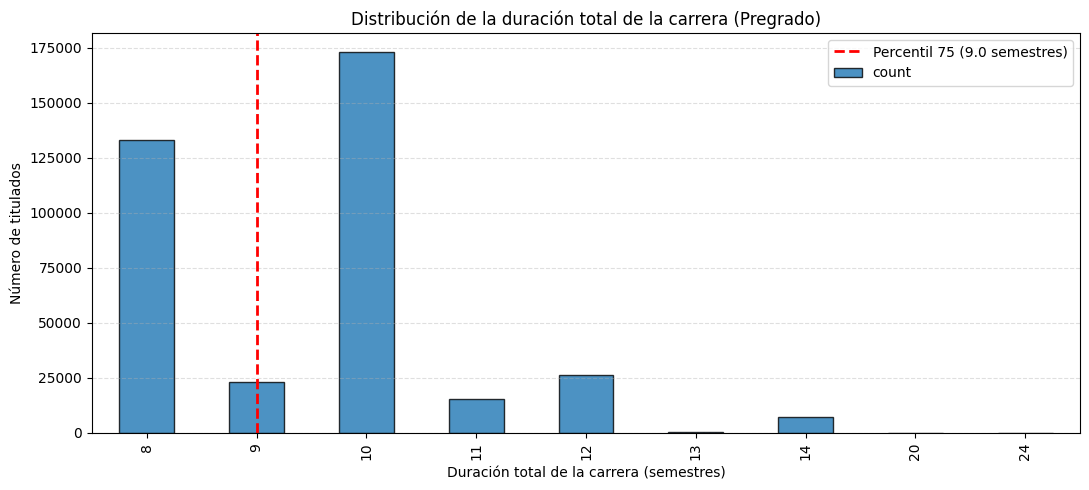

In [21]:
# Gráfico de barras de la duración total de la carrera (pregrado)

dur_counts = df_pregrado["dur_total_carr"].value_counts().sort_index()

x_pos_p75 = list(dur_counts.index).index(p75)

plt.figure(figsize=(11, 5))

dur_counts.plot(
    kind="bar",
    edgecolor="black",
    alpha=0.8
)

# Línea del percentil 75
plt.axvline(
    x=x_pos_p75,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Percentil 75 ({p75} semestres)"
)

plt.xlabel("Duración total de la carrera (semestres)")
plt.ylabel("Número de titulados")
plt.title("Distribución de la duración total de la carrera (Pregrado)")

plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


Si bien el percentil 75 de la duración total de la carrera corresponde a 10 semestres, 
la acumulación de observaciones indica que dicho umbral se alcanza dentro de la categoría 
de 9 semestres, lo cual se refleja visualmente en la Figura X. Esto se debe al carácter 
discreto de la variable, medida en semestres.



### 3.2 Análisis descriptivo "area_conocimiento"

In [22]:
df_pregrado["area_conocimiento"].value_counts()


area_conocimiento
Tecnología                   87295
Salud                        78855
Administración y Comercio    73195
Ciencias Sociales            52342
Educación                    34282
Arte y Arquitectura          19918
Derecho                      13436
Agropecuaria                  9379
Ciencias Básicas              6396
Humanidades                   3300
Name: count, dtype: int64

In [23]:
tabla_area = (df_pregrado.groupby("area_conocimiento")["sobreduracion"].mean().sort_values(ascending=False))

tabla_area

area_conocimiento
Derecho                     1.00
Salud                       0.99
Agropecuaria                0.77
Ciencias Básicas            0.74
Ciencias Sociales           0.62
Educación                   0.49
Arte y Arquitectura         0.46
Tecnología                  0.41
Administración y Comercio   0.32
Humanidades                 0.31
Name: sobreduracion, dtype: float64

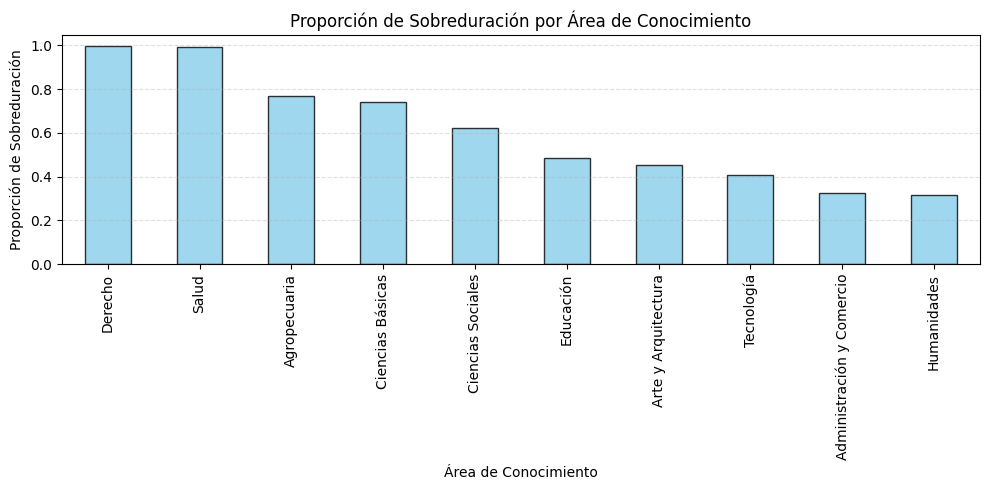

In [24]:
plt.figure(figsize=(10, 5))

tabla_area.plot(
    kind="bar",
    color="skyblue",
    edgecolor="black",
    alpha=0.8
)

plt.ylabel("Proporción de Sobreduración")
plt.xlabel("Área de Conocimiento")
plt.title("Proporción de Sobreduración por Área de Conocimiento")

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

El análisis exploratorio revela diferencias relevantes en la proporción de sobre-duración entre distintas 
áreas del conocimiento. Algunas áreas presentan una mayor prevalencia de titulaciones con duración superior 
a lo esperado, lo que sugiere que el área disciplinar constituye una variable explicativa relevante para el 
modelamiento predictivo.

In [25]:
df_pregrado["area_conocimiento"].value_counts()

area_conocimiento
Tecnología                   87295
Salud                        78855
Administración y Comercio    73195
Ciencias Sociales            52342
Educación                    34282
Arte y Arquitectura          19918
Derecho                      13436
Agropecuaria                  9379
Ciencias Básicas              6396
Humanidades                   3300
Name: count, dtype: int64

El análisis por área del conocimiento evidencia diferencias marcadas en la proporción de titulados con 
sobre-duración. El área de Salud presenta una proporción cercana al 99%, sustentada por un tamaño muestral 
elevado, lo que sugiere que la sobre-duración constituye un fenómeno ampliamente extendido en este ámbito. 

Por su parte, Derecho exhibe una proporción cercana al 100%, aunque este resultado debe interpretarse con 
mayor cautela debido a un menor número de observaciones relativas en comparación con otras áreas.

Las áreas de Agropecuaria y Ciencias Básicas muestran proporciones altas, en torno al 80%, mientras que 
Ciencias Sociales se sitúa cerca del 60% y Educación alrededor del 50%. En niveles intermedios-bajos se 
encuentran Arte y Arquitectura (≈45%) y Tecnología (≈40%), y finalmente Administración y Comercio junto con 
Humanidades presentan las proporciones más bajas de sobre-duración, cercanas al 30%.

Estas diferencias, observadas sobre tamaños muestrales heterogéneos, sugieren que el área del conocimiento 
es una variable asociada a la probabilidad de sobre-duración, aunque no permiten establecer relaciones 
causales directas.


### 3.3 Análisis descriptivo "tipo_inst_1"

In [26]:
df_pregrado["tipo_inst_1"].value_counts()

tipo_inst_1
Universidades               270645
Institutos Profesionales    107753
Name: count, dtype: int64

In [27]:
tabla_inst = (df_pregrado.groupby("tipo_inst_1")["sobreduracion"].mean().sort_values(ascending=False))

tabla_inst

tipo_inst_1
Universidades              0.81
Institutos Profesionales   0.03
Name: sobreduracion, dtype: float64

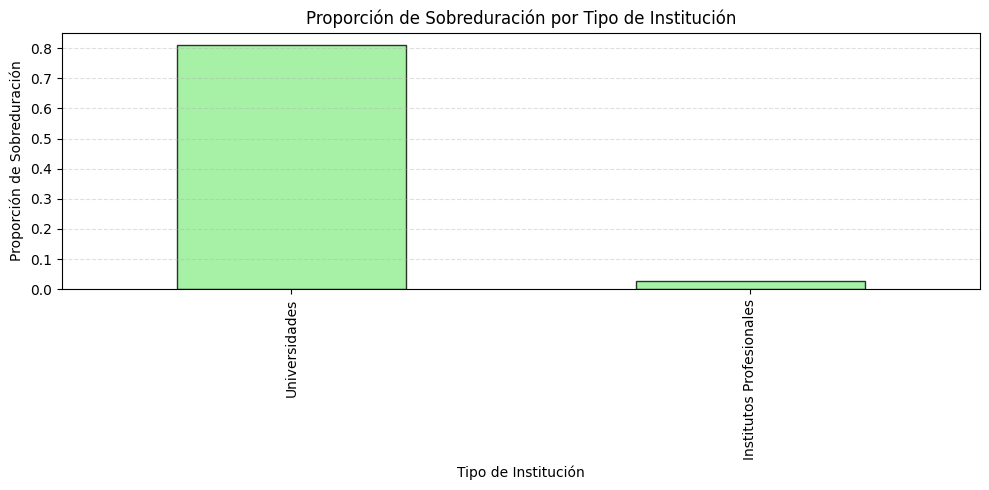

In [28]:
plt.figure(figsize=(10, 5))

tabla_inst.plot(
    kind="bar",
    color="lightgreen",
    edgecolor="black",
    alpha=0.8
)

plt.ylabel("Proporción de Sobreduración")
plt.xlabel("Tipo de Institución")
plt.title("Proporción de Sobreduración por Tipo de Institución")

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

El análisis por tipo de institución muestra diferencias muy marcadas en la proporción de titulados con 
sobre-duración. En el caso de las universidades, aproximadamente un 81% de los estudiantes presenta una 
duración total superior al umbral definido, mientras que en los institutos profesionales esta proporción 
es considerablemente menor, cercana al 3–5%.

Estas diferencias deben interpretarse con cautela. Si bien podrían estar asociadas a la mayor complejidad 
estructural y académica de las carreras universitarias, también es relevante considerar la composición del 
conjunto de datos, donde cerca del 70% de las observaciones corresponden a universidades y alrededor del 
28% a institutos profesionales. Asimismo, la definición del umbral de sobre-duración basada en percentiles 
globales podría afectar de manera distinta a instituciones con duraciones nominales más acotadas.

En consecuencia, el tipo de institución se perfila como una variable fuertemente asociada a la sobre-duración, 
aunque estas diferencias deben entenderse como asociaciones descriptivas y no como relaciones causales.

Cabe destacar que la marcada diferencia observada entre tipos de institución podría estar influida por la 
naturaleza discreta de la duración de los programas y por la definición global del umbral de sobre-duración, 
lo cual será considerado en la etapa de modelamiento.



### 3.4 Cruce multivariable

In [29]:
pd.crosstab(
    df_pregrado["area_conocimiento"],
    df_pregrado["tipo_inst_1"],
    values=df_pregrado["sobreduracion"],
    aggfunc="mean"
).sort_values(by="Universidades", ascending=False)

tipo_inst_1,Institutos Profesionales,Universidades
area_conocimiento,,
Derecho,NaN,1.00
Salud,0.92,1.00
Agropecuaria,0.00,0.99
Ciencias Sociales,0.00,0.81
Ciencias Básicas,0.00,0.80
Tecnología,0.00,0.76
Arte y Arquitectura,0.03,0.72
Administración y Comercio,0.01,0.66
Educación,0.00,0.56


In [30]:
df_pregrado.groupby("dur_estudio_carr")["sobreduracion"].mean()


dur_estudio_carr
4    0.00
5    1.00
6    0.92
7    0.00
8    0.00
9    0.03
10   1.00
11   1.00
12   1.00
14   1.00
20   1.00
24   1.00
Name: sobreduracion, dtype: float64

Se observa una relación no monótona entre la duración formal y la sobre-duración. Sin embargo, algunos valores presentan proporciones extremas (0 o 1), lo que sugiere tamaños muestrales reducidos o una fuerte asociación estructural entre duración formal y duración real en ciertos programas.


In [31]:
df_pregrado.groupby("tipo_inst_1")["dur_total_carr"].quantile(0.75)


tipo_inst_1
Institutos Profesionales    8.00
Universidades              10.00
Name: dur_total_carr, dtype: float64

El percentil 75 de la duración total difiere entre tipos de institución, lo que refleja estructuras curriculares distintas y valida el uso de un umbral relativo para definir la sobre-duración.

## 4. Análisis inferencial

### 4.1 Asociación entre variables categóricas y sobre-duración

In [32]:
tabla = pd.crosstab(df_pregrado["tipo_inst_1"], df_pregrado["sobreduracion"])
chi2, p, dof, expected = chi2_contingency(tabla)

chi2, p

(np.float64(195042.56959318285), np.float64(0.0))

In [33]:
n = tabla.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(tabla.shape) - 1)))
cramers_v

np.float64(0.717943534557892)

In [34]:
tabla_area = pd.crosstab(df_pregrado["area_conocimiento"], df_pregrado["sobreduracion"])
chi2_a, p_a, _, _ = chi2_contingency(tabla_area)

n_a = tabla_area.sum().sum()
cramers_v_a = np.sqrt(chi2_a / (n_a * (min(tabla_area.shape) - 1)))

p_a, cramers_v_a

(np.float64(0.0), np.float64(0.5192995377071059))

Los resultados del análisis inferencial muestran asociaciones estadísticamente significativas entre la
sobre-duración y las variables tipo de institución y área de conocimiento (p < 0.001). El tamaño del
efecto, medido mediante Cramér’s V, fue particularmente alto para el tipo de institución (V ≈ 0.72),
lo que indica una asociación muy fuerte. Asimismo, el área de conocimiento presentó un tamaño de
efecto elevado (V ≈ 0.52), sugiriendo que ambas variables poseen un alto poder explicativo y justifican
su inclusión en la etapa de modelado predictivo.


## 5. Modelado predictivo

### 5.1 Definir variable objetivo

In [35]:
y = df_pregrado["sobreduracion"]

In [37]:
X = df_pregrado[
    ["tipo_inst_1", "area_conocimiento", "dur_estudio_carr", "gen_alu", "jornada"]
]

### 5.2 Encoding de variables categóricas

In [38]:
X_encoded = pd.get_dummies(X, drop_first=True)
X_encoded.head()

,dur_estudio_carr,gen_alu,tipo_inst_1_Universidades,area_conocimiento_Agropecuaria,area_conocimiento_Arte y Arquitectura,area_conocimiento_Ciencias Básicas,area_conocimiento_Ciencias Sociales,area_conocimiento_Derecho,area_conocimiento_Educación,area_conocimiento_Humanidades,area_conocimiento_Salud,area_conocimiento_Tecnología,jornada_Diurna,jornada_Otra,jornada_Semipresencial,jornada_Vespertina
1,10,2,True,False,False,False,True,False,False,False,False,False,True,False,False,False
2,10,2,True,False,False,False,False,False,False,False,True,False,True,False,False,False
4,10,2,True,False,False,False,False,False,False,False,True,False,True,False,False,False
6,8,1,False,True,False,False,False,False,False,False,False,False,True,False,False,False
7,8,1,False,False,False,False,False,False,False,False,False,True,True,False,False,False


### 5.3 Train/Test Split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

El conjunto de datos fue dividido en subconjuntos de entrenamiento y prueba utilizando una proporción
70/30, manteniendo la distribución de la variable objetivo mediante muestreo estratificado. Las variables
categóricas fueron transformadas mediante codificación one-hot, eliminando una categoría de referencia
para evitar problemas de multicolinealidad.

### 5.4 Moodelo Baseline: Regresión logística

In [42]:
model_log = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)

model_log.fit(X_train, y_train)

c:\Users\adanm\Documentos\Magister en Ciencia de datos (UDLA)\8. Machine Learning II\venv-8\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

### 5.5 Evaluación inicial

In [44]:
y_pred = model_log.predict(X_test)
y_proba = model_log.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     46818
           1       1.00      1.00      1.00     66702

    accuracy                           1.00    113520
   macro avg       1.00      1.00      1.00    113520
weighted avg       1.00      1.00      1.00    113520

ROC-AUC: 0.9995640513782853


El modelo baseline presentó un desempeño prácticamente perfecto, con valores cercanos a 1.0 en todas
las métricas evaluadas. Este resultado sugiere la presencia de información altamente determinante en
las variables predictoras, particularmente aquellas relacionadas con la duración nominal de los
programas y el tipo de institución. En este contexto, el modelo no estaría capturando patrones
complejos de comportamiento, sino aprendiendo relaciones estructurales casi determinísticas, lo que
limita su utilidad predictiva en escenarios reales.


Reentrenamiento

In [45]:
X = df_pregrado[
    ["tipo_inst_1", "area_conocimiento"]
]

X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

model_log.fit(X_train, y_train)

c:\Users\adanm\Documentos\Magister en Ciencia de datos (UDLA)\8. Machine Learning II\venv-8\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [46]:
y_pred = model_log.predict(X_test)
y_proba = model_log.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.98      0.68      0.81     46818
           1       0.82      0.99      0.90     66702

    accuracy                           0.87    113520
   macro avg       0.90      0.84      0.85    113520
weighted avg       0.89      0.87      0.86    113520

ROC-AUC: 0.9288862567007113


Una vez eliminadas variables con potencial fuga de información, el modelo de regresión logística
presentó un desempeño sólido, alcanzando una exactitud del 87% y un valor ROC-AUC cercano a 0.93.
Destaca especialmente el alto recall obtenido para la clase de sobre-duración (0.99), lo que indica
una elevada capacidad del modelo para identificar casos en riesgo. Estos resultados sugieren que
variables estructurales como el tipo de institución y el área de conocimiento permiten una
predicción robusta de la sobre-duración, incluso en ausencia de información individual del estudiante.


## 6. Validación cruzada

In [48]:
model_log = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

roc_auc_scores = cross_val_score(
    model_log,
    X_encoded,
    y,
    cv=cv,
    scoring="roc_auc"
)

roc_auc_scores, roc_auc_scores.mean(), roc_auc_scores.std()

c:\Users\adanm\Documentos\Magister en Ciencia de datos (UDLA)\8. Machine Learning II\venv-8\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\adanm\Documentos\Magister en Ciencia de datos (UDLA)\8. Machine Learning II\venv-8\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\adanm\Documentos\Magister en Ciencia de datos (UDLA)\8. Machine Learning II\venv-8\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\adanm\Docu

(array([0.93003206, 0.92898842, 0.92942109, 0.92845978, 0.92739286]),
 np.float64(0.928858842580923),
 np.float64(0.000896404168236231))

### 7. Árbol de desición

In [50]:
tree_model = DecisionTreeClassifier(
    max_depth=5,
    random_state=42
)

tree_model.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

In [51]:
y_pred_tree = tree_model.predict(X_test)
y_proba_tree = tree_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_tree))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_tree))

              precision    recall  f1-score   support

           0       0.98      0.68      0.81     46818
           1       0.82      0.99      0.90     66702

    accuracy                           0.87    113520
   macro avg       0.90      0.84      0.85    113520
weighted avg       0.89      0.87      0.86    113520

ROC-AUC: 0.9175464959165645


La validación cruzada estratificada de 5 particiones aplicada al modelo de regresión logística
arrojó un valor promedio de ROC-AUC de 0.929, con una desviación estándar inferior a 0.001.
Estos resultados evidencian un desempeño alto y consistente entre las distintas particiones,
lo que sugiere una adecuada capacidad de generalización del modelo.


| Modelo              | ROC-AUC   | Estabilidad | Interpretabilidad |
| ------------------- | --------- | ----------- | ----------------- |
| Regresión logística | **0.929** | Alta        | Alta              |
| Árbol de decisión   | 0.918     | Media       | Media             |


### 8. Random Forest

In [53]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=50,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",50
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(

In [54]:
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

              precision    recall  f1-score   support

           0       0.98      0.68      0.81     46818
           1       0.82      0.99      0.90     66702

    accuracy                           0.87    113520
   macro avg       0.90      0.84      0.85    113520
weighted avg       0.89      0.87      0.86    113520

ROC-AUC: 0.9299850950519997


In [73]:
importances_rf = pd.Series(
    rf_model.feature_importances_,
    index=X_encoded.columns
).sort_values(ascending=False)

importances_rf



tipo_inst_1_Universidades               0.73
area_conocimiento_Salud                 0.18
area_conocimiento_Derecho               0.03
area_conocimiento_Tecnología            0.02
area_conocimiento_Educación             0.01
area_conocimiento_Agropecuaria          0.01
area_conocimiento_Ciencias Sociales     0.01
area_conocimiento_Humanidades           0.01
area_conocimiento_Ciencias Básicas      0.00
area_conocimiento_Arte y Arquitectura   0.00
dtype: float64

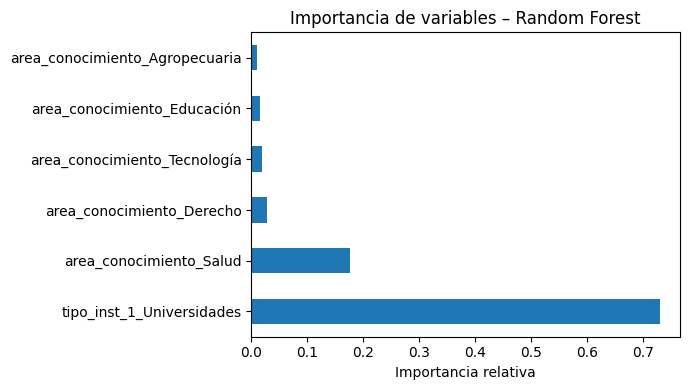

In [75]:
importances_rf.head(6).plot(kind="barh", figsize=(7, 4))
plt.xlabel("Importancia relativa")
plt.title("Importancia de variables – Random Forest")
plt.tight_layout()
plt.savefig("importancia_variables_rf_top6.png", dpi=300)
plt.show()

Los resultados obtenidos muestran que la sobre-duración de las carreras de pregrado puede ser
predicha con alta precisión utilizando únicamente variables estructurales como el tipo de
institución y el área de conocimiento. Tanto la regresión logística como el modelo de Random Forest
alcanzaron valores de ROC-AUC cercanos a 0.93, evidenciando una elevada capacidad discriminativa.
No obstante, el uso de modelos más complejos no produjo mejoras sustantivas respecto al modelo
baseline, lo que sugiere que el fenómeno está dominado por relaciones mayormente lineales.
El análisis de importancia de variables confirma que el tipo de institución es el principal
factor asociado a la sobre-duración, seguido por el área de la salud, mientras que otras áreas
aportan información marginal.


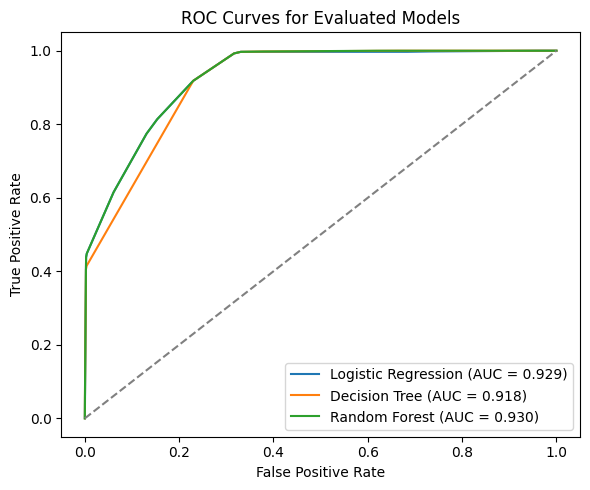

In [ ]:
# Curvas ROC de los modelos evaluados

plt.figure(figsize=(6, 5))

# Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba)
roc_log = auc(fpr_log, tpr_log)
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_log:.3f})")

# Decision Tree
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_proba_tree)
roc_tree = auc(fpr_tree, tpr_tree)
plt.plot(fpr_tree, tpr_tree, label=f"Decision Tree (AUC = {roc_tree:.3f})")

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_rf:.3f})")

# Baseline
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Evaluated Models")
plt.legend()
plt.tight_layout()
plt.show()


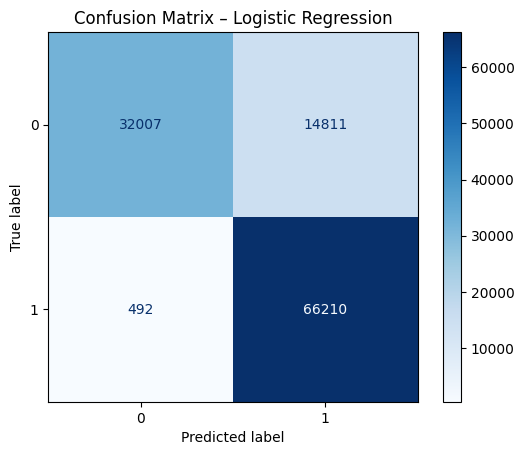

In [59]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap="Blues"
)
plt.title("Confusion Matrix – Logistic Regression")
plt.show()

El desempeño de los modelos fue complementado mediante representaciones gráficas, incluyendo
curvas ROC y matrices de confusión, con el fin de evaluar visualmente la capacidad discriminativa
y los patrones de error de cada clasificador.
